## Segmentation of users

We are going to play with the following dataset

1.- **Dataset name to request access:** SQLaaSPulseAnonymizedSimple-1

2.- **Athena (SQLaaS):** {provider}_databox.insights_sessions_fact_layer_7d

3.- **S3 path** schibsted-spt-common-prod/yellow/pulse-simple/version=1-alpha/*/client=${provider}


We are going to do a query per users and activity and then we are going to do a segmentation based on activity (# of days) and type of activity as follows:

![](pictures/segmentation.png)

In [3]:
# Needed packages
from pyathena import connect
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from getpass import getpass
access_key = getpass(prompt="Enter your access key to databox: ")
secret_key = getpass(prompt="Enter your secret to databox: ")

# Some parameters (different way to extract the credential)
user = "maria.pelaez@schibsted.com/"
provider ='yapocl'

# Establishing the connection
conn = connect(aws_access_key_id=access_key,
               aws_secret_access_key=secret_key,
               s3_staging_dir="s3://schibsted-spt-common-dev/user-areas/"+ user,
               region_name="eu-west-1")

Enter your access key to databox: ········
Enter your secret to databox: ········


## Step 0: What information is available in this dataset?

In [5]:
describe_events = """
SELECT * FROM {}_databox.yellow_pulse_simple_7d LIMIT 1
"""
pd.read_sql(describe_events.format(provider), conn).dtypes

category               object
name                   object
objectlatitude         object
objectlongitude        object
objectid               object
url                    object
items                  object
objecttype             object
useragent              object
providerid             object
providerurl            object
providerproduct        object
providerproducttype    object
environmentid          object
isloggedin               bool
jweids                 object
screensize             object
pageviewid             object
sptpageviewid          object
id                     object
type                   object
latitude               object
longitude              object
locationaccuracy       object
locationtimestamp      object
originurl              object
published              object
trackertype            object
intent                 object
objectintent           object
devicetype             object
version                object
year                    int64
month     

In [26]:
%%time

query1 = """
SELECT
 environmentid,
 sum(nof_listings) as nof_listings,
 sum(nof_classifieds) as nof_classifieds,
 sum(nof_pages) as nof_pages,
 sum(nof_created) as nof_created,
 sum(nof_call) as nof_call,
 sum(nof_Show) as nof_Show,
 sum(nof_Send) as nof_Send,
 sum(nof_SMS) as nof_SMS
 FROM
 (
  SELECT
      environmentid,
      CASE WHEN (type='View' and objecttype = 'Listing') THEN SUM(1) else 0 end as nof_listings,
      CASE WHEN (type='View' and objecttype = 'ClassifiedAd') THEN SUM(1) else 0 end as nof_classifieds,
      CASE WHEN (type='View' and objecttype = 'Content')  THEN SUM(1) else 0 end as nof_content,
      CASE WHEN (type='View' and objecttype = 'Page') THEN SUM(1) else 0 end as nof_pages,
      CASE WHEN (type='Create' and objecttype = 'ClassifiedAd' ) THEN SUM(1) else 0 end as nof_created,
      CASE WHEN (type='Call' and objecttype = 'PhoneContact') THEN SUM(1) else 0 end as nof_call,
      CASE WHEN (type='Show' and objecttype = 'PhoneContact') THEN SUM(1) else 0 end as nof_Show,
      CASE WHEN (type='Send' and objecttype = 'Message') THEN SUM(1) else 0 end as nof_Send,
      CASE WHEN (type='SMS' and objecttype = 'PhoneContact') THEN SUM(1) else 0 end as nof_SMS
    FROM
      {}_databox.yellow_pulse_simple_7d
    GROUP BY
      environmentid, 
      type,
      objecttype
 )
GROUP BY
  environmentid
;
"""

query2 = """
SELECT
      environmentid,
      count(distinct day) as active_days,
      count(environmentid) as total_events,
      count(nullif(isloggedin = true, false)) as total_logged_events
    FROM
      {}_databox.yellow_pulse_simple_7d
    GROUP BY
      environmentid
;
"""
#df1 = pd.read_sql(query1.format(provider), conn)
#df2 = pd.read_sql(query2.format(provider), conn)
#df = df2.merge(df1,on='environmentid',how='left')

CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 11 µs


In [27]:
# in case the query is long, we are going to use this fake data
df = pd.read_csv("aggregatedDataset_7d.csv")

In [28]:
df.head()

,environmentid,active_days,total_events,total_logged_events,nof_listings,nof_classifieds,nof_pages,nof_created,nof_call,nof_Show,nof_Send,nof_SMS
0,0,7,924,0,576,296,46,0,2,4,0,0
1,1,6,181,0,127,53,1,0,0,0,0,0
2,2,1,10,0,10,0,0,0,0,0,0,0
3,3,3,159,0,20,133,6,0,0,0,0,0
4,4,7,587,0,425,156,4,0,0,0,1,0


## **Exercise 1**:

Create a function to apply the previous segmentation. After this, please answer the following questions:

1.1 What is the distribution of the segmentation?

1.2 What is the volume of total events that every segment consumes?

1.3 What is the distribution of active days per segment?

1.4 What are the main charactersitics of every segment?

> Please write the results in the cardboard of the site that you are studying


In [14]:
def assignSegment(row):
    if row["active_days"] >= 4:
        return "POWER"
    elif row["nof_listings"] / (row["total_events"]) >= 0.7:
        return "SEARCHER"
    elif row["nof_classifieds"] / (row["total_events"]) >= 0.7:
        return "WINDOW SHOPPER"
    elif (row["nof_listings"] + row["nof_classifieds"]) / (row["total_events"]) <= 0.2:
        return "NON BROWSER"
    else:
        return "AVERAGE"


In [47]:
%%time
df['segment'] = df.apply(lambda x: assignSegment(x), axis=1)

CPU times: user 1min 40s, sys: 517 ms, total: 1min 41s
Wall time: 1min 41s


DISTRIBUTION OF SEGMENTS

In [48]:
table = 100 * df["segment"].value_counts(normalize=True)

WHAT IS THE VOLUME OF EVENTS CONSUMED BY EACH SEGMENT

In [49]:
segments_counts = df.groupby("segment")["total_events"].sum()

In [50]:
segments_counts / segments_counts.sum()

segment
AVERAGE           0.329506
NON BROWSER       0.011650
POWER             0.581186
SEARCHER          0.061828
WINDOW SHOPPER    0.015830
Name: total_events, dtype: float64

In [51]:
segments = df.groupby('segment').agg({'environmentid':'nunique',
                                      'total_events':'sum'}).reset_index()
segments.head()

,segment,total_events,environmentid
0,AVERAGE,41151686,1014947
1,NON BROWSER,1454943,169922
2,POWER,72583647,311594
3,SEARCHER,7721570,467560
4,WINDOW SHOPPER,1977049,217216


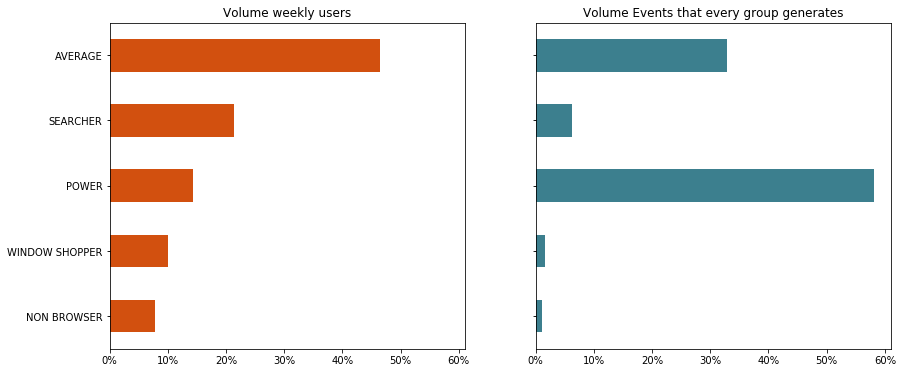

In [52]:
segments['volume'] = 100 * segments['environmentid']/segments['environmentid'].sum()
segments['volume_ev'] = 100 * segments['total_events']/segments['total_events'].sum()
plt.rcParams['figure.figsize'] = (14, 6)
fig, ax = plt.subplots(1,2, sharey=True,sharex=True)
segments.sort_values('environmentid').plot(x='segment',y='volume',kind='barh',
                                   ax=ax[0],color='#D2500F',legend=False)
ax[0].set_title('Volume weekly users')
segments.sort_values('environmentid').plot(x='segment',y='volume_ev',kind='barh',
                                   ax=ax[1],color='#3C7F8E',legend=False)
ax[1].set_title('Volume Events that every group generates')
ax[0].set_ylabel("")
vals0 = ax[0].get_xticks()
_ = ax[0].set_xticklabels(['{:g}%'.format(x) for x in vals0])

> What are the characteristics of every segment?

In [53]:
df['perc_lis'] = 100*df['nof_listings']/df['total_events']
df['perc_av'] = 100*df['nof_classifieds']/df['total_events']
df['log_events'] = 100* df['total_logged_events']/df['total_events']
df['leads'] = df['nof_SMS']+df['nof_Send']+df['nof_Show']+df['nof_call']
df['listings per day'] = df['nof_listings']/df['active_days']
df['adviews per day'] = df['nof_classifieds']/df['active_days']
df['pages per day'] = df['nof_pages']/df['active_days']

In [54]:
active_features = df.groupby('segment').agg({'environmentid':'nunique',
                                             'active_days':'mean',
                                             'perc_lis':'mean',
                                             'perc_av':'mean'}).reset_index()
pasive_features1 = df.groupby('segment').agg({'environmentid':'nunique',
                                              'listings per day':'mean',
                                             'adviews per day':'mean',
                                             'pages per day':'mean'}).reset_index()
pasive_features2 = df.groupby('segment').agg({'environmentid':'nunique',
                                              'log_events':'mean',
                                              'leads':'mean',
                                              'nof_created':'mean'}).reset_index()

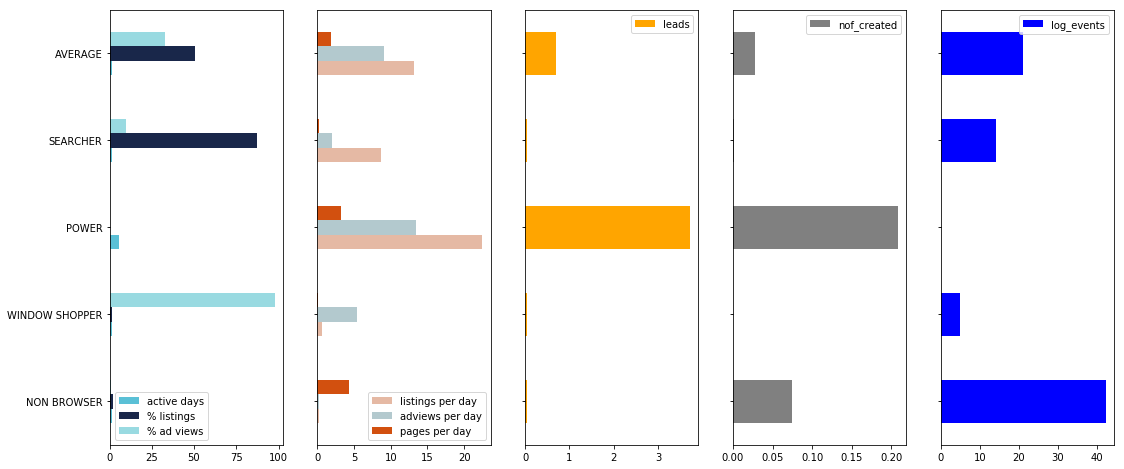

In [57]:
color1 = ['#5ac0d6','#19274a','#99DAE1']
color2 = ['#E5B9A4','#B3C9CE','#D2500F']
color3 = ['#84D2DE','#4DA2BB','#336582']

fig1, ax1 = plt.subplots(1,5, sharey=True,figsize=(18,8))
aux = active_features.sort_values('environmentid')
aux.index = aux.segment
aux[['active_days','perc_lis','perc_av']].plot(kind='barh',ax=ax1[0],color=color1)
ax1[0].legend(['active days','% listings', '% ad views'])
ax1[0].set_ylabel("")

aux = pasive_features1.sort_values('environmentid')
aux.index = aux.segment
aux[['listings per day','adviews per day','pages per day']].plot(kind='barh',ax=ax1[1],color=color2)
ax1[1].set_ylabel("")

aux = pasive_features2.sort_values('environmentid')
aux.index = aux.segment
aux[['leads']].plot(kind='barh',ax=ax1[2],color='orange')
ax1[2].set_ylabel("")

aux = pasive_features2.sort_values('environmentid')
aux.index = aux.segment
aux[['nof_created']].plot(kind='barh',ax=ax1[3],color='gray')
ax1[3].set_ylabel("")

aux = pasive_features2.sort_values('environmentid')
aux.index = aux.segment
aux[['log_events']].plot(kind='barh',ax=ax1[4],color='blue')
ax1[4].set_ylabel("")

WHAT IS THE DISTRIBUTION OF ACTIVE DAYS BY SEGMENT

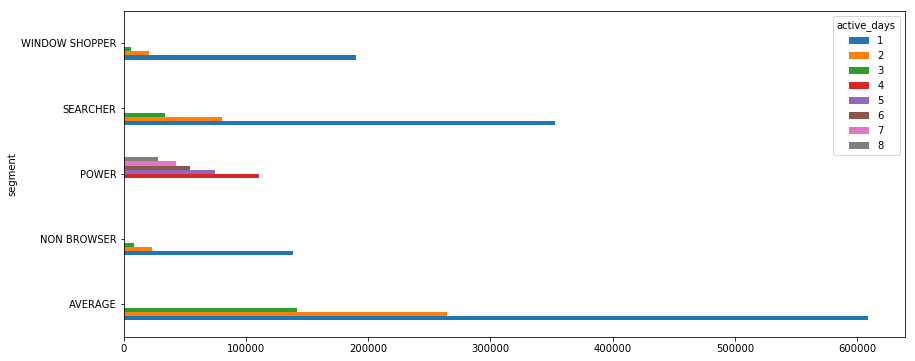

In [58]:
df.groupby(['segment','active_days']).agg({'environmentid':'count'})\
                                     .reset_index()\
                                     .pivot_table(index='segment',
                                                  columns='active_days',
                                                  values='environmentid')\
                                     .plot(kind='barh')
        

In [59]:
df.groupby("segment")["active_days"].mean()

segment
AVERAGE           1.540390
NON BROWSER       1.235979
POWER             5.368634
SEARCHER          1.317087
WINDOW SHOPPER    1.152369
Name: active_days, dtype: float64

## **Exercise 2** (difficulty medium):

[Recency, frequency and monetary](https://en.wikipedia.org/wiki/RFM_(customer_value)) is another way to segment our users. Using `{}_databox.yellow_pulse_simple_7d` create a query to extract the following for eeach user:
- number of active days,
- day of the first visit
- day of the last visit
- total number of events

Do a weekly RFM of our users using the features above.

Any interesting conclusions?

**Hint**: use [pandas.cut](https://pandas.pydata.org/pandas-docs/version/0.23.4/generated/pandas.cut.html)

In [60]:
query = """
SELECT
 environmentid, 
 count(distinct day) AS active_days, 
 min(published) as day_first_visit, 
 max(published) as day_last_visit, 
 count(environmentid) nof_events
FROM yapocl_databox.yellow_pulse_simple_7d 
GROUP BY
environmentid
"""

In [61]:
%%time
df_rfm = pd.read_sql(query, conn)

CPU times: user 1min 40s, sys: 3.27 s, total: 1min 43s
Wall time: 12min 13s


In [62]:
df_rfm["day_first_visit"] = pd.to_datetime(df_rfm["day_first_visit"], 
                                           infer_datetime_format=True)

In [63]:
df_rfm["day_last_visit"] = pd.to_datetime(df_rfm["day_last_visit"], 
                                          infer_datetime_format=True)

RECENCY

In [68]:
df_rfm["today"] = pd.Timestamp.now()

In [69]:
df_rfm["days since last visit"] = (df_rfm["today"] - df_rfm["day_last_visit"]).dt.days

In [70]:
df_rfm["recency segment"] = pd.cut(df_rfm["days since last visit"], bins=3, labels=["recent", "medium", "not recent"])

In [71]:
df_rfm["recency segment"].value_counts(normalize=True)

recent        0.537708
not recent    0.260085
medium        0.202207
Name: recency segment, dtype: float64

In [72]:
df_rfm.groupby("recency segment")["days since last visit"].mean()

recency segment
recent        0.726295
medium        3.483152
not recent    5.588303
Name: days since last visit, dtype: float64

FREQUENCY

In [73]:
df_rfm["frequency segment"] = pd.cut(df_rfm["active_days"], bins=3, labels=["not frequent", "medium", "frequent"])

In [74]:
df_rfm.head()

,environmentid,active_days,day_first_visit,day_last_visit,nof_events,today,days since last visit,recency segment,frequency segment
0,sdrn:schibsted:environment:19ffd1f9-b4c0-4023-...,5,2018-10-29 22:02:22,2018-11-04 07:58:29,145,2018-11-05 14:34:54.223119,1,recent,medium
1,sdrn:schibsted:environment:230e7c19-8b20-406f-...,1,2018-11-04 07:17:23,2018-11-04 07:29:08,17,2018-11-05 14:34:54.223119,1,recent,not frequent
2,sdrn:schibsted:environment:fb2dd6aa-c497-4a59-...,8,2018-10-29 13:20:05,2018-11-05 07:18:21,846,2018-11-05 14:34:54.223119,0,recent,frequent
3,sdrn:schibsted:environment:76b822b1-bb3c-4bbd-...,5,2018-10-30 22:09:37,2018-11-05 10:50:28,216,2018-11-05 14:34:54.223119,0,recent,medium
4,sdrn:schibsted:environment:3c6b91e5-23bd-42a6-...,6,2018-10-29 12:25:38,2018-11-05 04:47:10,469,2018-11-05 14:34:54.223119,0,recent,frequent


In [75]:
df_rfm["frequency segment"].value_counts(normalize=True)

not frequent    0.855864
medium          0.085505
frequent        0.058631
Name: frequency segment, dtype: float64

In [78]:
df_rfm.groupby("frequency segment")["active_days"].mean()

frequency segment
not frequent    1.411713
medium          4.401368
frequent        6.820232
Name: active_days, dtype: float64

In [ ]:
## MONETORY

In [80]:
df_rfm["monetory segment"] = pd.cut(df_rfm["nof_events"], bins=3, labels=["low consumer", "medium comsumer", "high consumer"])

In [81]:
df_rfm["monetory segment"].value_counts(normalize=True)

low consumer       9.999863e-01
medium comsumer    1.283185e-05
high consumer      9.165605e-07
Name: monetory segment, dtype: float64

In [82]:
df_rfm.groupby("monetory segment")["nof_events"].mean()

monetory segment
low consumer          57.154608
medium comsumer     5969.607143
high consumer      12795.500000
Name: nof_events, dtype: float64

In [83]:
df_rfm.head(3)

,environmentid,active_days,day_first_visit,day_last_visit,nof_events,today,days since last visit,recency segment,frequency segment,monetory segment
0,sdrn:schibsted:environment:19ffd1f9-b4c0-4023-...,5,2018-10-29 22:02:22,2018-11-04 07:58:29,145,2018-11-05 14:34:54.223119,1,recent,medium,low consumer
1,sdrn:schibsted:environment:230e7c19-8b20-406f-...,1,2018-11-04 07:17:23,2018-11-04 07:29:08,17,2018-11-05 14:34:54.223119,1,recent,not frequent,low consumer
2,sdrn:schibsted:environment:fb2dd6aa-c497-4a59-...,8,2018-10-29 13:20:05,2018-11-05 07:18:21,846,2018-11-05 14:34:54.223119,0,recent,frequent,low consumer


In [84]:
df_rfm.columns

Index(['environmentid', 'active_days', 'day_first_visit', 'day_last_visit',
       'nof_events', 'today', 'days since last visit', 'recency segment',
       'frequency segment', 'monetory segment'],
      dtype='object')

In [93]:
import seaborn as sns
def pattern_volume(rfmTable,column1,column2):
    tabla = rfmTable.groupby([column1,column2])['environmentid'].count()
    averamap = tabla.reset_index().pivot_table(index = column1 , 
                                               columns=column2,
                                               values='environmentid')
    averamap = round(averamap / rfmTable['environmentid'].nunique()*100)
    ax = sns.heatmap(averamap, annot=True, linewidths=.5)

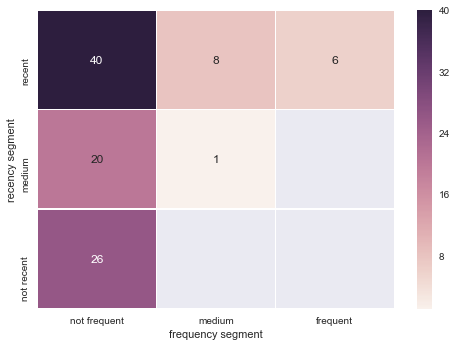

In [94]:
pattern_volume(df_rfm,'recency segment','frequency segment')

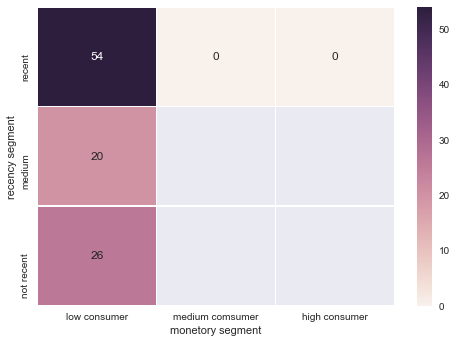

In [95]:
pattern_volume(df_rfm,'recency segment','monetory segment')

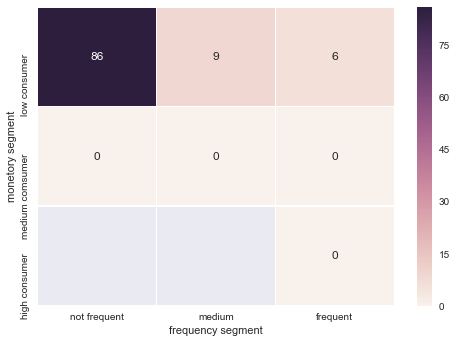

In [96]:
pattern_volume(df_rfm,'monetory segment','frequency segment')

## **Exercise 3** (difficulty high):

Add in your previous analysis the category dimension and try to extract some new insights related to the behaviour of our users.